In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import json
import os
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler

### Parameters

In [ ]:
# ---- About dataset (no need to change)
#
enhanced_dir     = './data'                  # Enhanced dataset is very small, so ./data in a good choice :-)
run_dir          = 'models'
dataset_filename = 'cleaned-donnees-synop-essentielles-omm(LYS).csv'
schema_filename  = 'new-description-synop-essentielles-omm(LYS).json'
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- About training (Can be changed !)
#
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .7       # Percentage for train (the rest being for the test)
validation_prop         = 0.15
sequence_len     = 16
batch_size       = 32
epochs           = 10
fit_verbosity    = 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/meteo_forecasting(fidle)"

/content/drive/MyDrive/Colab Notebooks/meteo_forecasting(fidle)


In [ ]:
df = pd.read_csv(f'{enhanced_dir}/{dataset_filename}', header=0, sep=";")

df = df[:int(scale*len(df))]
train_index=int(train_prop*len(df))
validation_index = int(len(df) * (train_prop + validation_prop))

train_set = df.loc[:train_index, features]
validation_set = df.loc[train_index:validation_index, features]
test_set = df.loc[validation_index:, features]

In [ ]:
train_set.head()

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,20.0,2.0,250.0,7.2,283.05,89,2.0,100700.0,11.8,0.0,0.0,11.7
1,-50.0,8.0,250.0,7.7,283.35,88,20.0,100650.0,12.3,0.0,0.0,12.1
2,-40.0,6.0,240.0,7.2,283.85,92,0.0,100610.0,10.3,0.0,0.0,12.0
3,-40.0,5.0,220.0,6.7,284.25,97,58.0,100570.0,9.8,0.0,0.0,11.6
4,40.0,0.0,220.0,6.7,284.65,97,58.0,100610.0,9.8,0.0,0.0,12.0


In [ ]:
# ---- Normalize, and convert to numpy array (manual StandardScaler)

mean = train_set.mean()
std  = train_set.std()
# train_set = (train_set - mean) / std # standardisation SandardScaler (les valeur diffèrents à la 4è décimale)
# test_set  = (test_set  - mean) / std

In [ ]:
std_scaler = StandardScaler()

X_train = std_scaler.fit_transform(train_set)
scaled_train_set = pd.DataFrame(X_train, columns=features)

X_val = std_scaler.fit_transform(validation_set)
X_test = std_scaler.transform(test_set)

display(scaled_train_set.describe().style.format("{0:.2f}"))
print('Dataset       : ',df.shape)
print('Train dataset : ',train_set.shape)
print('Validation dataset : ',validation_set.shape)
print('Test  dataset : ',test_set.shape)

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00,24134.00
mean,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-9.07,-1.60,-1.94,-1.68,-4.55,-3.63,-0.45,-4.52,-1.78,-0.40,-0.31,-3.46
25%,-0.53,-0.86,-0.69,-0.71,-0.69,-0.65,-0.45,-0.58,-0.77,-0.18,-0.22,-0.71
50%,-0.00,-0.49,0.14,-0.15,0.03,0.26,-0.45,0.06,-0.15,-0.18,-0.22,-0.06
75%,0.60,1.00,0.77,0.58,0.75,0.81,-0.34,0.68,0.57,-0.18,-0.22,0.69
max,10.05,1.37,1.81,6.00,2.73,1.35,4.94,3.30,6.28,26.81,40.39,4.44


Dataset       :  (34477, 14)
Train dataset :  (24134, 12)
Validation dataset :  (5173, 12)
Test  dataset :  (5172, 12)


In [ ]:
scaled_train_set

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,0.150277,-0.856208,0.663258,1.228146,0.529971,0.683671,-0.342349,-0.355739,1.145039,-0.177055,-0.219172,0.069566
1,-0.378525,1.368948,0.663258,1.430371,0.585400,0.622920,0.658428,-0.406849,1.269140,-0.177055,-0.219172,0.128362
2,-0.302982,0.627229,0.559104,1.228146,0.677781,0.865926,-0.453546,-0.447737,0.772738,-0.177055,-0.219172,0.113663
3,-0.302982,0.256370,0.350795,1.025922,0.751685,1.169684,2.771180,-0.488626,0.648637,-0.177055,-0.219172,0.054867
4,0.301364,-1.597927,0.350795,1.025922,0.825590,1.169684,2.771180,-0.447737,0.648637,-0.177055,-0.219172,0.113663
...,...,...,...,...,...,...,...,...,...,...,...,...
24129,0.376907,-0.485349,-1.523984,0.217023,-0.135170,-2.293160,-0.453546,0.819792,0.524537,-0.177055,-0.219172,1.348368
24130,0.905709,-1.227068,-1.628139,0.095688,0.160449,-1.078127,-0.453546,0.942456,-0.195247,-0.177055,-0.219172,0.642822
24131,0.074734,-1.597927,-1.523984,-0.227871,-0.098217,-0.895872,-0.453546,0.952678,-0.468268,-0.177055,-0.219172,0.319447
24132,-0.302982,1.368948,-1.523984,-0.308761,-0.190598,-0.531362,-0.453546,0.911790,-0.468268,-0.177055,-0.219172,0.040168


In [ ]:
train_generator = TimeseriesGenerator(X_train, X_train, length=sequence_len,  batch_size=batch_size)
validation_generator  = TimeseriesGenerator(X_val,  X_val,  length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(X_test,  X_test,  length=sequence_len,  batch_size=batch_size)


x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator)) # .__len__()
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)


print('What a batch looks like (x[0]) :')
# print(x[0])
print(f'shape x[0]: {x[0].shape}')
print('What a batch looks like (y[0]) :')
# print(y[0])
print(f'shape y[0]: {y[0].shape}')

# print(train_generator.get_config())

Nombre de train batchs disponibles :  754
batch x shape :  (32, 16, 12)
batch y shape :  (32, 12)
What a batch looks like (x[0]) :
shape x[0]: (16, 12)
What a batch looks like (y[0]) :
shape y[0]: (12,)


### Create model

In [ ]:
from keras.layers import InputLayer, LSTM, Dropout, Dense

In [ ]:
model1 = keras.models.Sequential()

model1.add(InputLayer(input_shape=(sequence_len, features_len)))
model1.add(LSTM(100, activation='tanh'))
model1.add(Dropout(0.2))
model1.add(Dense(features_len))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               45200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12)                1212      
                                                                 
Total params: 46412 (181.30 KB)
Trainable params: 46412 (181.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Using ReLU for LSTM

In [ ]:
model2 = keras.models.Sequential()

model2.add(InputLayer(input_shape=(sequence_len, features_len)))
model2.add(LSTM(100, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(features_len))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               45200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12)                1212      
                                                                 
Total params: 46412 (181.30 KB)
Trainable params: 46412 (181.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Clallback and compile

In [ ]:
%ls

 data/        forecast_01.2.ipynb  'meteo_forecasting(Fidle).ipynb'
 data.ipynb   forecast_01.ipynb     models/


In [ ]:
# %mkdir 'model1'
save_dir = f'{run_dir}/model1'
cb = ModelCheckpoint(filepath=save_dir, save_best_only=True)

model1.compile(
      loss='mse',
      optimizer=Adam(),
      metrics=['mae'] # MeanAbsoluteError
    )

In [ ]:
%mkdir 'model2'
save_dir = f'{run_dir}/model2'
cb = ModelCheckpoint(filepath=save_dir, save_best_only=True)

model2.compile(
      loss='mse',
      optimizer=Adam(),
      metrics=['mae'] # MeanAbsoluteError
    )

mkdir: cannot create directory ‘model2’: File exists


In [ ]:
history=model1.fit(train_generator,
                  epochs  = epochs,
                  verbose = fit_verbosity,
                  validation_data = validation_generator,
                  callbacks = [cb])


Epoch 1/10
754/754 [==============================] - 19s 22ms/step - loss: 0.5504 - mae: 0.4681 - val_loss: 0.4535 - val_mae: 0.3818
Epoch 2/10
754/754 [==============================] - 16s 21ms/step - loss: 0.4456 - mae: 0.3939 - val_loss: 0.4262 - val_mae: 0.3614
Epoch 3/10
754/754 [==============================] - 15s 20ms/step - loss: 0.4264 - mae: 0.3781 - val_loss: 0.4149 - val_mae: 0.3528
Epoch 4/10
754/754 [==============================] - 14s 18ms/step - loss: 0.4167 - mae: 0.3704 - val_loss: 0.4111 - val_mae: 0.3491
Epoch 5/10
754/754 [==============================] - 15s 20ms/step - loss: 0.4114 - mae: 0.3670 - val_loss: 0.4067 - val_mae: 0.3415
Epoch 6/10
754/754 [==============================] - 15s 20ms/step - loss: 0.4068 - mae: 0.3635 - val_loss: 0.4057 - val_mae: 0.3384
Epoch 7/10
754/754 [==============================] - 15s 20ms/step - loss: 0.4040 - mae: 0.3615 - val_loss: 0.4028 - val_mae: 0.3391
Epoch 8/10
754/754 [==============================] - 15s 20ms

In [ ]:
history2=model2.fit(train_generator,
                  epochs  = epochs,
                  verbose = fit_verbosity,
                  validation_data = validation_generator,
                  callbacks = [cb])

Epoch 1/10
754/754 [==============================] - 16s 15ms/step - loss: 0.5665 - mae: 0.4844 - val_loss: 0.4602 - val_mae: 0.3974
Epoch 2/10
754/754 [==============================] - 13s 17ms/step - loss: 0.4660 - mae: 0.4148 - val_loss: 0.4352 - val_mae: 0.3694
Epoch 3/10
754/754 [==============================] - 11s 15ms/step - loss: 0.4464 - mae: 0.3981 - val_loss: 0.4268 - val_mae: 0.3665
Epoch 4/10
754/754 [==============================] - 14s 18ms/step - loss: 0.4365 - mae: 0.3898 - val_loss: 0.4210 - val_mae: 0.3577
Epoch 5/10
754/754 [==============================] - 13s 17ms/step - loss: 0.4278 - mae: 0.3833 - val_loss: 0.4139 - val_mae: 0.3506
Epoch 6/10
754/754 [==============================] - 13s 17ms/step - loss: 0.4213 - mae: 0.3779 - val_loss: 0.4099 - val_mae: 0.3391
Epoch 7/10
754/754 [==============================] - 14s 18ms/step - loss: 0.4170 - mae: 0.3746 - val_loss: 0.4078 - val_mae: 0.3441
Epoch 8/10
754/754 [==============================] - 13s 18ms

### Predict

In [ ]:
loaded_model = tf.keras.models.load_model(f'models/model1/') # tanh

In [ ]:
loaded_model2 = tf.keras.models.load_model(f'models/model2/') # relu

In [ ]:
s=random.randint(0,len(X_test)-sequence_len)

sequence      = X_test[s:s+sequence_len]
sequence_true = X_test[s:s+sequence_len+1]

In [ ]:
pd.DataFrame(sequence, columns=features).describe()

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.681614,-0.293592,0.541136,1.307497,-0.884236,-0.214575,-0.198962,-1.928136,1.300110,-0.187959,-0.023663,-0.648006
std,2.195565,0.876055,0.620774,2.296202,0.475684,0.714119,0.721826,0.610530,2.153587,0.077603,0.758330,0.441736
min,-4.126475,-1.219094,-0.830346,-1.357323,-1.534842,-1.516322,-0.379418,-2.975558,-1.332465,-0.318104,-0.318393,-1.555478
25%,-0.971641,-0.848893,0.271967,-0.440962,-1.143535,-0.851299,-0.379418,-2.427422,-0.665672,-0.187959,-0.224079,-0.916413
50%,1.050689,-0.478692,0.707765,0.643925,-1.016243,-0.157977,-0.379418,-1.787930,0.831467,-0.144578,-0.224079,-0.693654
75%,2.082077,0.354260,0.810305,2.845299,-0.742799,0.422150,-0.379418,-1.554464,2.668294,-0.144578,-0.224079,-0.306563
max,3.881951,1.372312,1.630631,5.847172,0.086960,0.747587,2.507886,-0.793163,5.058685,-0.144578,2.793956,0.036706


Note (comprehension personnelle) : pour prédire une valeur de y (12 composantes), il faut une sequence de plusieurs valeurs comme entré x.

En entrainement le model prend des lots de sequence en entrée.

Puisque le model est entrainé sur des "batch" de sequence, on encadre d'une dimension la sequence de test pour 1 valeur à prédire.


In [ ]:
np.reshape(sequence, (1, sequence_len, features_len)).shape

(1, 16, 12)

In [ ]:
sequence.shape, np.array([sequence]).shape, X_test.shape,

((16, 12), (1, 16, 12), (5172, 12))

In [ ]:
pred = loaded_model.predict( np.array([sequence]) )  # wrap sequence in array to match train TimeseriesGenerator dimension (ex: (32, 16, 12) → 3d in entry)
# pred2 = loaded_model2.predict( np.array([sequence]) )  # wrap sequence in array to match train TimeseriesGenerator dimension (ex: (32, 16, 12) → 3d in entry)
df_pred = pd.DataFrame(std_scaler.inverse_transform(pred), columns=features)

1/1 [==============================] - 0s 27ms/step


In [ ]:
pred

array([[-0.2801096 ,  0.46350858, -1.4572656 ,  0.38455567, -1.1617311 ,
        -0.11962028, -0.38436157,  2.2645826 ,  0.2562345 , -0.19037287,
        -0.22613744, -0.94970536]], dtype=float32)

In [ ]:
def plot_multivariate(sequence, labels=None, predictions=None, only_features=None,
                            columns=3, width=5,height=4,wspace=0.3,hspace=0.2,ms=6,lw=1,
                            save_as='auto', time_dt=1, hide_ticks=False):

    sequence_len = len(sequence)
    features_len = sequence.shape[1]
    if only_features is None : only_features=range(features_len)
    if labels is None        : labels=range(features_len)

    t  = np.arange(sequence_len)
    if predictions is None:
        dt = 0
    else:
        dt = len(predictions)
        sequence_with_pred = sequence.copy()
        sequence_with_pred[-dt:]=predictions

    rows = math.ceil(features_len/columns)
    fig  = plt.figure(figsize=(columns*width, rows*height))
    # fig.subplots_adjust(wspace=0.3,hspace=0.2)
    n=1
    for i in only_features:
        ax=fig.add_subplot(rows, columns, n)

        # ---- Real sequence without prediction
        #
        ax.plot( t[:-dt],sequence[:-dt,i], 'o',  markersize=ms, color='C0', zorder=2)
        ax.plot( t,sequence[:,i],          '-',  linewidth=lw,  color='C0', label=labels[i],zorder=1)

        # ---- What we expect
        #
        ax.plot(t[-dt:], sequence[-dt:,i], 'o', markeredgecolor='C0',markerfacecolor='white',ms=6)

        if predictions is not None:
            ax.plot(t[-dt-1:], sequence_with_pred[-dt-1:,i], '--',  lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=1)
            ax.plot(t[-dt:],   predictions[:,i],             'o',   lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=2)

        ax.legend(loc="upper left")
        n+=1
    plt.show()

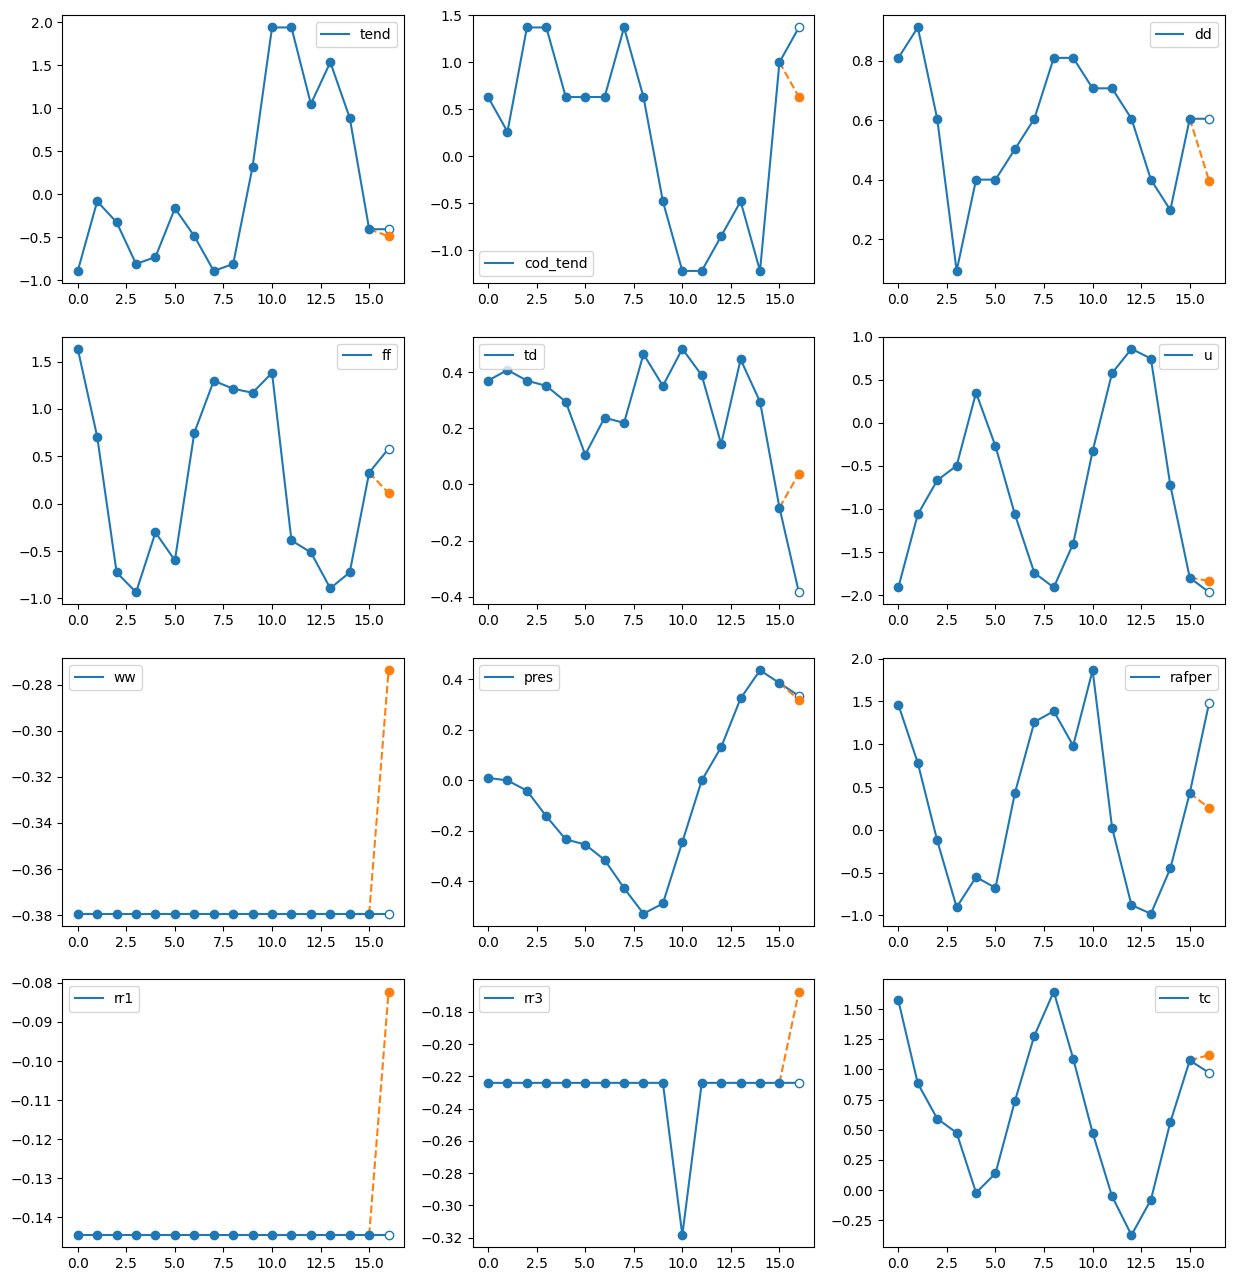

In [ ]:
columns = 3
rows = math.ceil(features_len/columns)
fig_w = 5*columns
fig_h = 4 * rows

t = np.arange(len(sequence_true))
predict_len = len(pred)
sequence_with_pred = sequence_true.copy()
sequence_with_pred[-predict_len:] = pred

fig = plt.figure(figsize=(fig_w, fig_h))
n=1
for i in range(features_len):
  ax = fig.add_subplot(rows, columns, n)

  # real
  ax.plot( t[:-predict_len], sequence_true[:-predict_len,i], 'o', color='C0', zorder=2 )
  ax.plot( t, sequence_true[:,i], '-',  color='C0', label=features[i],zorder=1 )

  ax.plot( t[-predict_len:], sequence_true[-predict_len:,i], 'o', markeredgecolor='C0',markerfacecolor='white',ms=6 )

  # prediction
  ax.plot( t[-predict_len-1:], sequence_with_pred[-predict_len-1:, i], linestyle='--', fillstyle='full',  color='C1',zorder=1 )
  ax.plot( t[-predict_len:], pred[:, i], marker='o', fillstyle='full', color='C1', zorder=2 )

  ax.legend()
  n = n+1
plt.show()

Non normalized prediction

In [ ]:
std_scaler.inverse_transform(df_pred)

array([[ 2.73730896e+02, -2.01341547e-02,  2.35356918e+02,
         3.41253304e+00,  2.73736816e+02,  8.66423950e+01,
         3.46132398e+00,  1.00763836e+05,  5.81847763e+00,
        -5.33631705e-02,  3.71147948e-03,  2.47725010e+00]], dtype=float32)

In [ ]:
sequence_true = std_scaler.inverse_transform(sequence_true)
pred = std_scaler.inverse_transform(pred)

In [ ]:
pred

array([[-0.2801096 ,  0.46350858, -1.4572656 ,  0.38455567, -1.1617311 ,
        -0.11962028, -0.38436157,  2.2645826 ,  0.2562345 , -0.19037287,
        -0.22613744, -0.94970536]], dtype=float32)

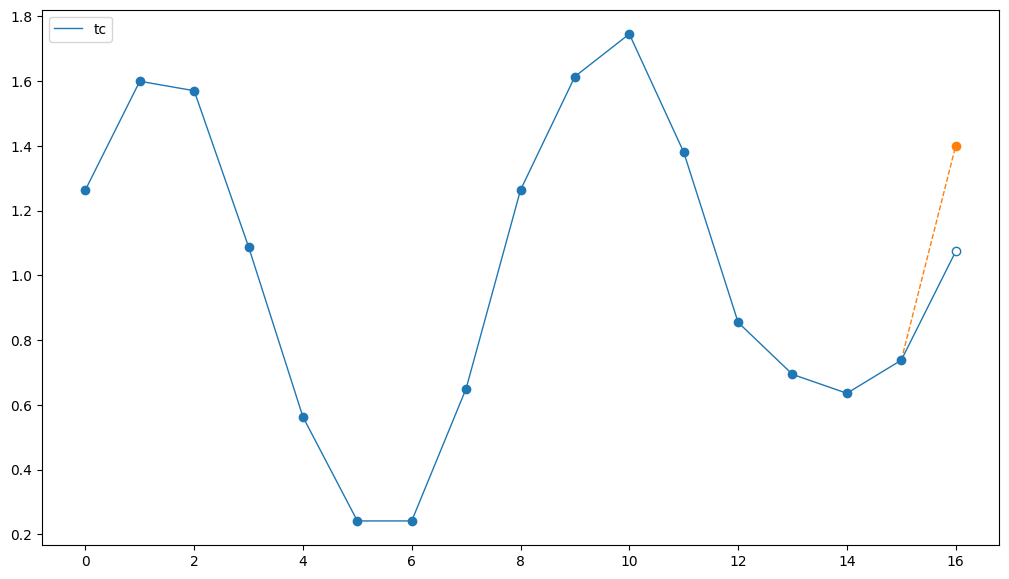

In [ ]:
feature=11
plot_multivariate(sequence_true, predictions=pred, labels=features, only_features=[feature],width=14, height=8, save_as='03-prediction')